In [29]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy.fftpack import fftfreq, fftshift, ifftshift, ifftn

In [23]:
init_density = 5
scale_rad = 500

In [24]:
# NFW Profile density of dark matter halos as a function of x, y, z coordinates
halo_density = lambda init_density, scale_rad, x, y, z: init_density / ((np.sqrt(x**2 + y**2 + z**2) / scale_rad) * (1 + np.sqrt(x**2 + y**2 + z**2) / scale_rad) ** 2)

In [25]:
Lbox = 512.0 # size of box in Mpc/h
Ngrid = 256 # number of cells in 1D of grid for power spectrum
bin_centers = np.arange(Ngrid) # integer linear space up to number of cells for as bin centers
Lgrid = Lbox / Ngrid # the size of each individual grid cell

In [63]:
def azimuthalAverage3D(grid, edges = None, logbins = True, bins = 50):
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
     
    if grid.shape[0]%2 == 0:
        center+=0.5
     
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)#distance to center pixel, for each pixel
 
    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # the index to sort by r
    i_sorted = grid.flat[ind] # the index of the images sorted by r
 
    # find index that's corresponding to the lower edge of each bin
    kmin=1.0
    kmax=grid.shape[0]/2.0
    if edges == None:
        if logbins:
            edges = np.logspace(np.log10(kmin),np.log10(kmax),bins+1)
        else:
            #edges = linspace(kmin,kmax+0.001,bins+1)    
            edges = np.linspace(kmin,kmax,bins+1)
    if edges[0] > 0:
        edges = np.append([0],edges)
         
    hist_ind = np.histogram(r_sorted,bins = edges)[0] # hist_ind: the number in each ell bins, sum them up is the index of lower edge of each bin, first bin spans from 0 to left of first bin edge.    
    hist_sum = np.cumsum(hist_ind)
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[hist_sum[1:]] - csim[hist_sum[:-1]]
    radial_prof = tbin / hist_ind[1:]
    return edges[1:], radial_prof

edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])

def PowerSpectrum3D(grid, logbins = True, bins=50):
    # Calculate the power spectrum for a cube.
    # Input:
    # grid = input grid in numpy array.
    # Output:
    # k, psd1D
    isize = grid.shape[0]
    F = fftshift(fftpack.fftn(grid))
    psd3D = np.abs(F)**2
    k_arr, psd1D = azimuthalAverage3D(psd3D, logbins = logbins, bins=bins)
    k_arr = edge2center(k_arr)
    return k_arr, psd1D
 
def process_ps_density(grid):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    k, ps3d = PowerSpectrum3D(grid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed

def plot_power_density(grid):
    
    k, p = process_ps_density(grid)
    
    #plt.plot(k, p)
    #plt.title("(6/25/18) Halo Power Spectrum MNV = 0.1, z = 1")
    #plt.xlabel("k (1/r)")
    #plt.ylabel("Power Density (log10(mass))")
    #plt.show()
    
    plt.plot(k, p, label = "NFW Profile Model")
    plt.title("(7/13/18) log-log DM Halo Power Spectrum")
    plt.xlabel("log(k) (log(1/r))")
    plt.ylabel("Power Density")
    plt.xscale('log')
    plt.yscale('log')
    

In [64]:
def process_ps(grid_filename):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    igrid = np.load(grid_filename)
    k, ps3d = PowerSpectrum3D(igrid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed

def plot_power_spectrum(grid_filename, label):
    
    k, p = process_ps(grid_filename)
    
    #plt.plot(k, p)
    #plt.title("(6/25/18) Halo Power Spectrum MNV = 0.1, z = 1")
    #plt.xlabel("k (1/r)")
    #plt.ylabel("Power Density (log10(mass))")
    #plt.show()
    
    plt.plot(k, p, label = label)

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


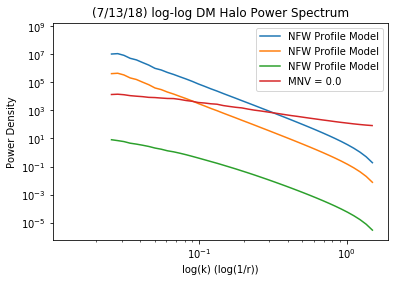

In [79]:
xs = np.linspace(- Lbox / 2, Lbox / 2, Ngrid)
ys = np.linspace(- Lbox / 2, Lbox / 2, Ngrid)
zs = np.linspace(- Lbox / 2, Lbox / 2, Ngrid)

x, y, z = grid = np.meshgrid(xs, ys, zs)

density_grid = halo_density(5, 1000, x, y, z) / Lgrid
denisty_grid = density_grid / np.mean(density_grid) - 1
plot_power_density(density_grid)

density_grid = halo_density(1, 1000, x, y, z) / Lgrid
denisty_grid = density_grid / np.mean(density_grid) - 1
plot_power_density(density_grid)

density_grid = halo_density(1, 20, x, y, z) / Lgrid
denisty_grid = density_grid / np.mean(density_grid) - 1
plot_power_density(density_grid)
plot_power_spectrum("/u/ayannam/Documents/Grids/mnv_0.0/out_37_parents_grid.npy", "MNV = 0.0")
plt.legend()
plt.show()



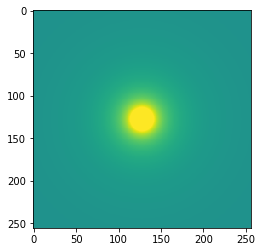

In [67]:
def plot_grid(grid):
    plt.imshow(np.sum(grid, axis = 0), vmin = -5 * np.std(np.sum(grid, axis = 0)), vmax = 5 * np.std(np.sum(grid, axis = 0)))
    
plot_grid(density_grid)